# Uplift Curves with TMLE Example

This notebook demonstrates the issue of using uplift curves without knowing true treatment effect and how to solve it by using TMLE as a proxy of the true treatment effect.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
base_path = os.path.abspath("../")
os.chdir(base_path)

In [3]:
import logging
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import sys
import warnings
warnings.simplefilter("ignore", UserWarning)

from lightgbm import LGBMRegressor

In [4]:
import causalml

from causalml.dataset import synthetic_data
from causalml.inference.meta import BaseXRegressor, TMLELearner
from causalml.metrics.visualize import *
from causalml.propensity import calibrate

import importlib
print(importlib.metadata.version('causalml') )

Failed to import duecredit due to No module named 'duecredit'


0.15.3.dev0


In [5]:
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)
plt.style.use('fivethirtyeight')

## Generating Synthetic Data

In [6]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=1000000, p=10, sigma=5.)

In [7]:
X_train, X_test, y_train, y_test, e_train, e_test, treatment_train, treatment_test, tau_train, tau_test, b_train, b_test = train_test_split(X, y, e, treatment, tau, b, test_size=0.5, random_state=42)

## Calculating Individual Treatment Effect (ITE/CATE)

In [8]:
# X Learner
learner_x = BaseXRegressor(learner=LGBMRegressor())
learner_x.fit(X=X_train, treatment=treatment_train, y=y_train)
cate_x_test = learner_x.predict(X=X_test, p=e_test, treatment=treatment_test).flatten()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 240455, number of used features: 10
[LightGBM] [Info] Start training from score 1.025470
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 259545, number of used features: 10
[LightGBM] [Info] Start training from score 1.931372
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

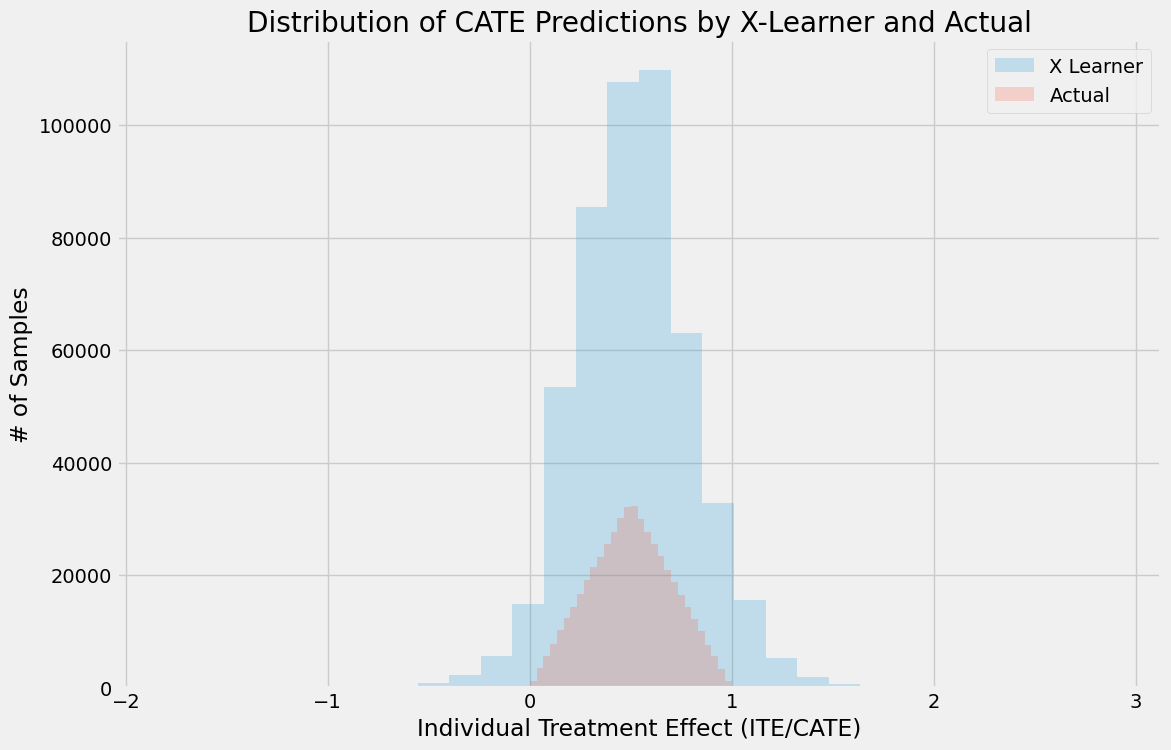

In [9]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_x_test, alpha=alpha, bins=bins, label='X Learner')
plt.hist(tau_test, alpha=alpha, bins=bins, label='Actual')

plt.title('Distribution of CATE Predictions by X-Learner and Actual')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

## Validating CATE without TMLE

In [10]:
df = pd.DataFrame({'y': y_test, 'w': treatment_test, 'tau': tau_test, 'X-Learner': cate_x_test, 'Actual': tau_test})

### Uplift Curve With Ground Truth

If true treatment effect is known as in simulations, the uplift curve of a model uses the cumulative sum of the treatment effect sorted by model's CATE estimate.

In the figure below, the uplift curve of X-learner shows positive lift close to the optimal lift by the ground truth.

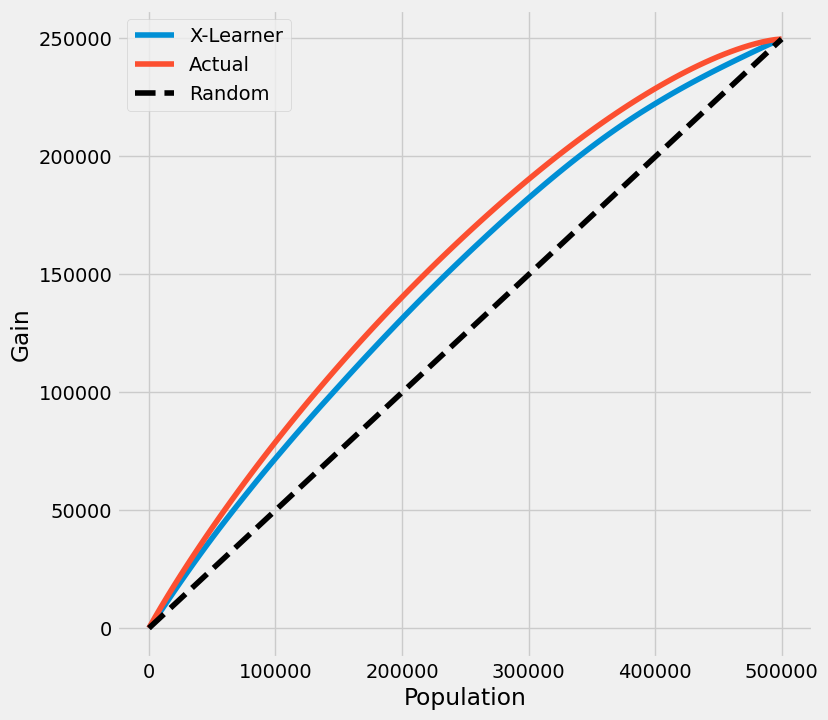

In [11]:
plot(df, outcome_col='y', treatment_col='w', treatment_effect_col='tau')

### Uplift Curve Without Ground Truth

If true treatment effect is unknown as in practice, the uplift curve of a model uses the cumulative mean difference of outcome in the treatment and control group sorted by model's CATE estimate.

In the figure below, the uplift curves of X-learner as well as the ground truth show no lift incorrectly.

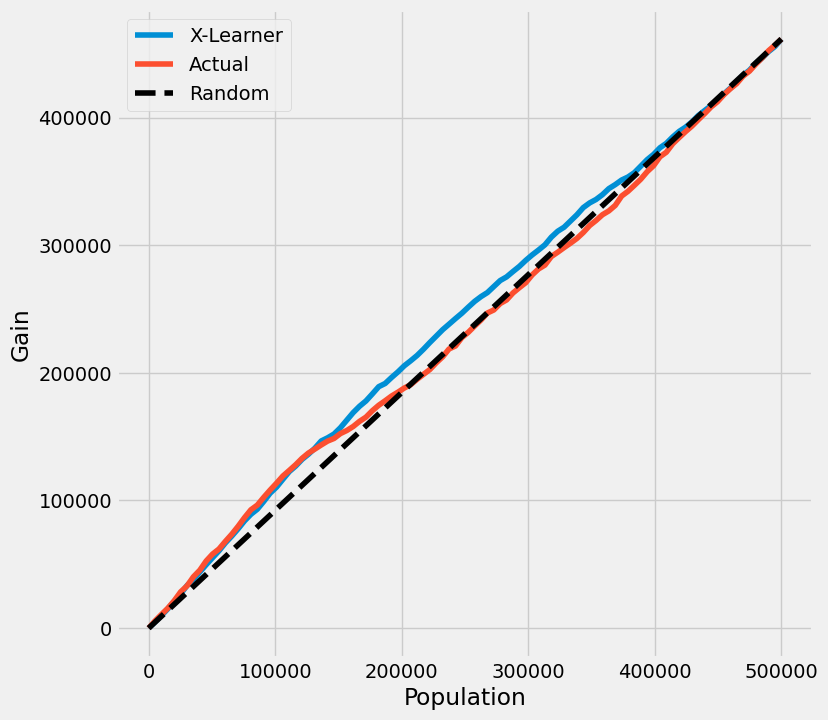

In [12]:
plot(df.drop('tau', axis=1), outcome_col='y', treatment_col='w')

## TMLE 

### Uplift Curve with TMLE as Ground Truth

By using TMLE as a proxy of the ground truth, the uplift curves of X-learner and the ground truth become close to the original using the ground truth.

In [13]:
n_fold = 5
kf = KFold(n_splits=n_fold)

In [14]:
df = pd.DataFrame({'y': y_test, 'w': treatment_test, 'p': e_test, 'X-Learner': cate_x_test, 'Actual': tau_test})

In [15]:
inference_cols = []
for i in range(X_test.shape[1]):
    col = 'col_' + str(i)
    df[col] = X_test[:,i]
    inference_cols.append(col)

In [16]:
df.head()

,y,w,p,X-Learner,Actual,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9
0,2.299468,0,0.875235,0.689955,0.812923,0.801219,0.824627,0.418361,0.576936,0.810729,0.186007,0.883184,0.057571,0.084963,0.782511
1,-2.601411,1,0.715290,0.950119,0.864145,0.885407,0.842883,0.014536,0.974505,0.858550,0.548230,0.164607,0.762274,0.198254,0.647855
2,9.295828,1,0.895537,0.675432,0.637853,0.406232,0.869474,0.808828,0.525918,0.526959,0.023063,0.903683,0.566092,0.242138,0.219698
3,2.362346,0,0.230146,0.555949,0.497591,0.914335,0.080846,0.501873,0.912275,0.405199,0.922577,0.054477,0.054306,0.385622,0.244462
4,-6.428204,1,0.772851,0.541349,0.551009,0.700812,0.401207,0.450781,0.988744,0.537332,0.124579,0.700980,0.135383,0.087629,0.198028


In [17]:
tmle_df = get_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                       n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.506199
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.492271
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [18]:
tmle_df

,X-Learner,Actual
0.0,0.000000,0.000000
0.2,0.162729,0.181960
0.4,0.289292,0.312707
0.6,0.401203,0.413857
0.8,0.474771,0.496008
1.0,0.536501,0.536501


#### Uplift Curve wihtout CI

Here we can directly use `plot_tmle()` function to generate the results and plot uplift curve

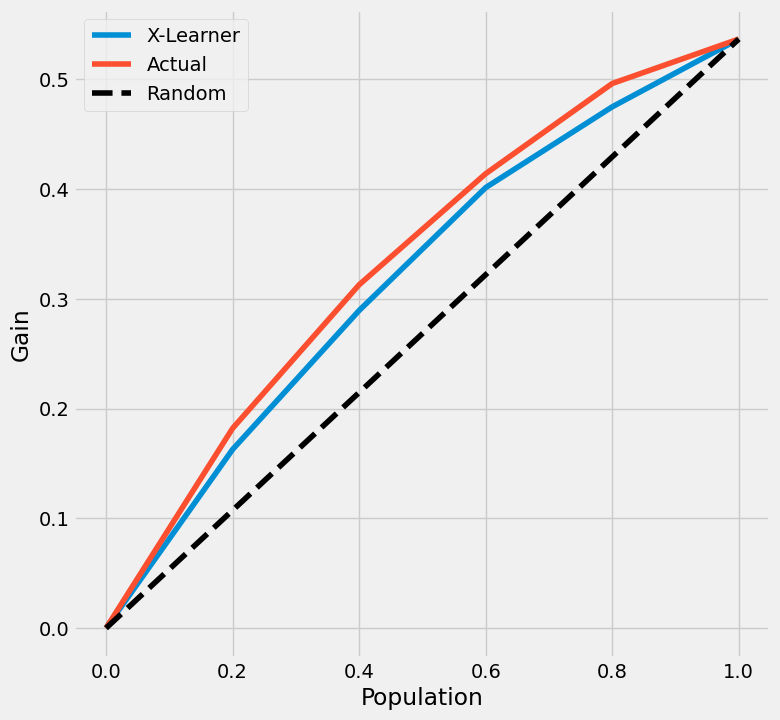

In [19]:
plot_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

We also provide the api call directly with `plot()` by input `kind='gain'` and `tmle=True`

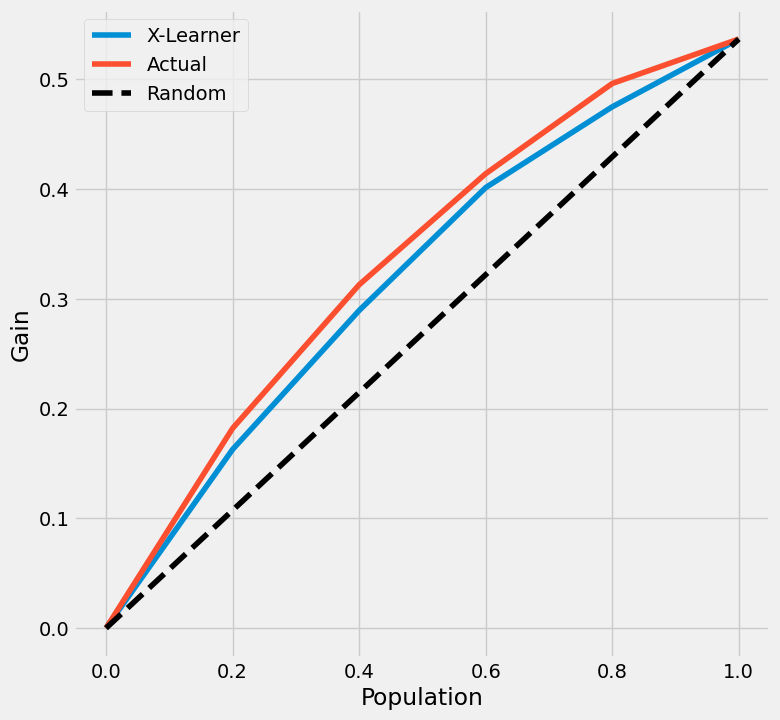

In [20]:
plot(df, kind='gain', tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

#### AUUC Score

In [21]:
auuc_score(df, tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
           n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

X-Learner    0.310749
Actual       0.323505
dtype: float64

#### Uplift Curve with CI

In [22]:
tmle_df = get_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                       n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

In [23]:
tmle_df

,X-Learner,Actual,X-Learner LB,Actual LB,X-Learner UB,Actual UB
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.2,0.162729,0.181960,0.144712,0.162806,0.180746,0.201114
0.4,0.289292,0.312707,0.253433,0.275556,0.325151,0.349859
0.6,0.401203,0.413857,0.349491,0.362746,0.452916,0.464968
0.8,0.474771,0.496008,0.407328,0.429929,0.542213,0.562086
1.0,0.536501,0.536501,0.498278,0.498278,0.574724,0.574724


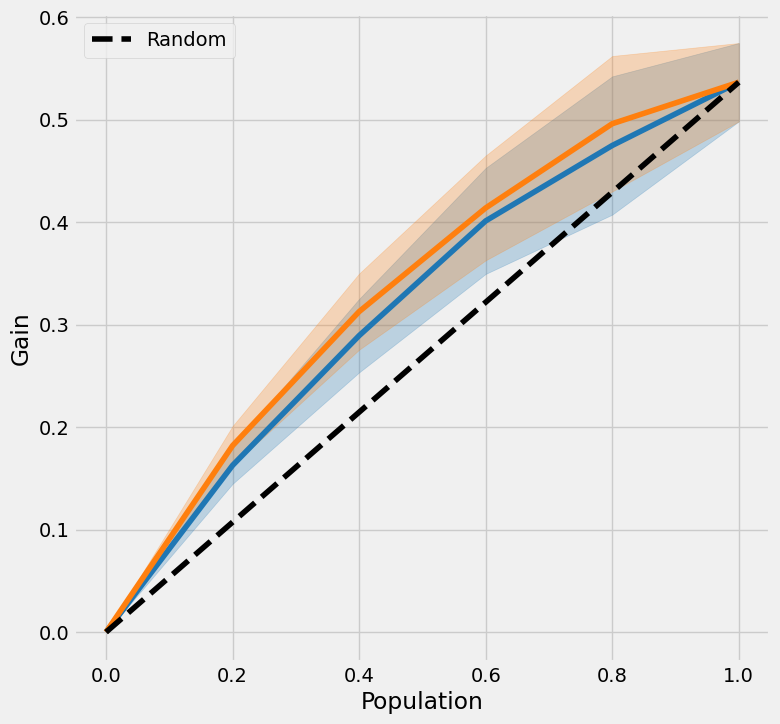

In [24]:
plot_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

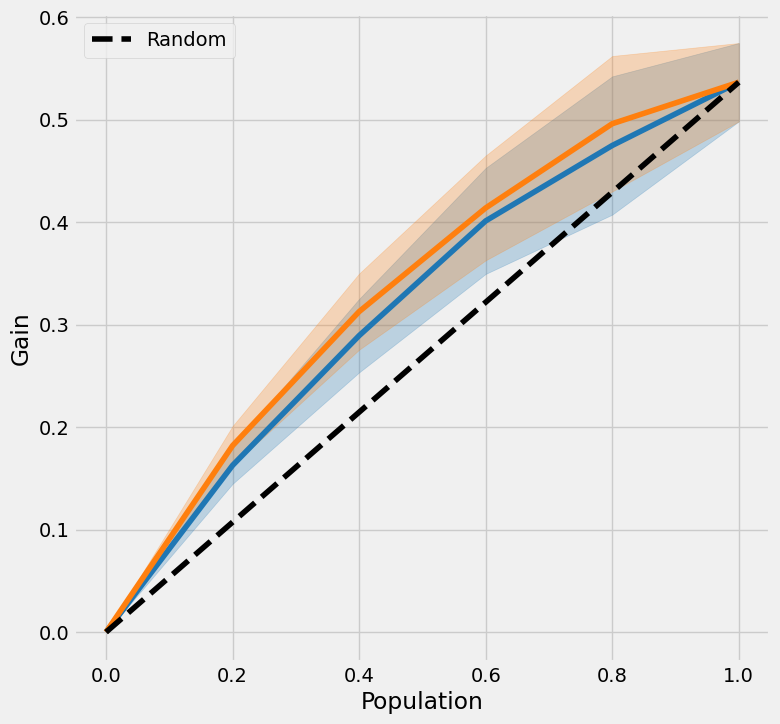

In [25]:
plot(df, kind='gain', tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

### Qini Curve with TMLE as Ground Truth

#### Qini Curve without CI

In [26]:
qini = get_tmleqini(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                    n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

In [27]:
qini

,X-Learner,Actual
0.0,0.000000,0.000000
100000.0,59451.339999,74162.340931
200000.0,103923.696240,127661.597180
300000.0,135436.896364,153502.216545
400000.0,149594.578171,166344.875062
500000.0,138989.103266,138989.103266


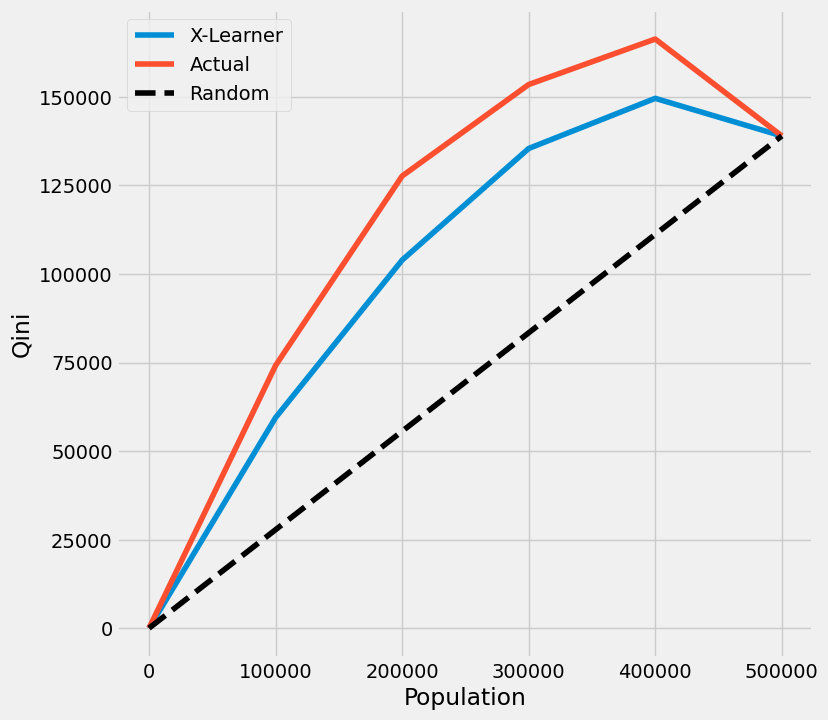

In [28]:
plot_tmleqini(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

We also provide the api call directly with `plot()` by input `kind='qini'` and `tmle=True`

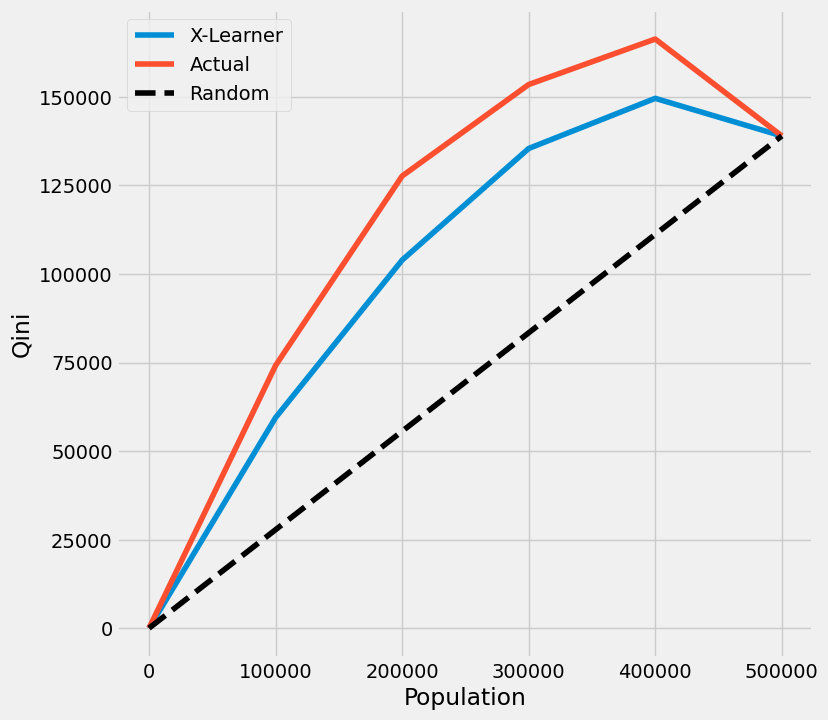

In [29]:
plot(df, kind='qini', tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

#### Qini Score

In [30]:
qini_score(df, tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
           n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

X-Learner    28404.717374
Actual       40615.470531
Random           0.000000
dtype: float64

#### Qini Curve with CI

In [31]:
qini = get_tmleqini(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                    n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

In [32]:
qini

,X-Learner,Actual,X-Learner LB,Actual LB,X-Learner UB,Actual UB
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100000.0,59451.339999,74162.340931,52869.065243,66355.766067,66033.614756,81968.915795
200000.0,103923.696240,127661.597180,91071.983173,112490.548288,116775.409307,142832.646073
300000.0,135436.896364,153502.216545,118121.046182,134765.053280,152752.746546,172239.379810
400000.0,149594.578171,166344.875062,129251.502323,145267.815499,169937.654019,187421.934626
500000.0,138989.103266,138989.103266,138989.103266,138989.103266,138989.103266,138989.103266


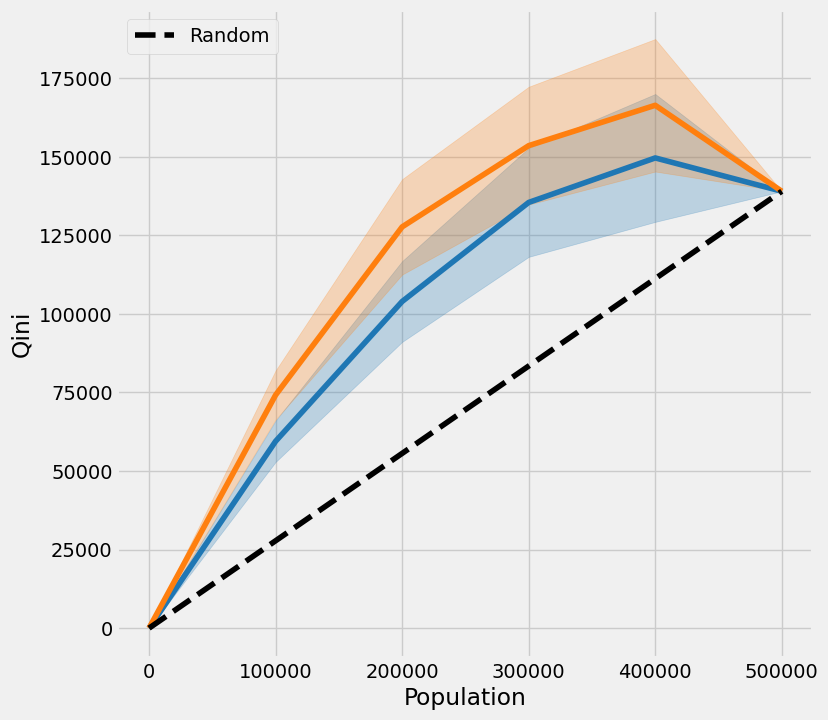

In [33]:
plot_tmleqini(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

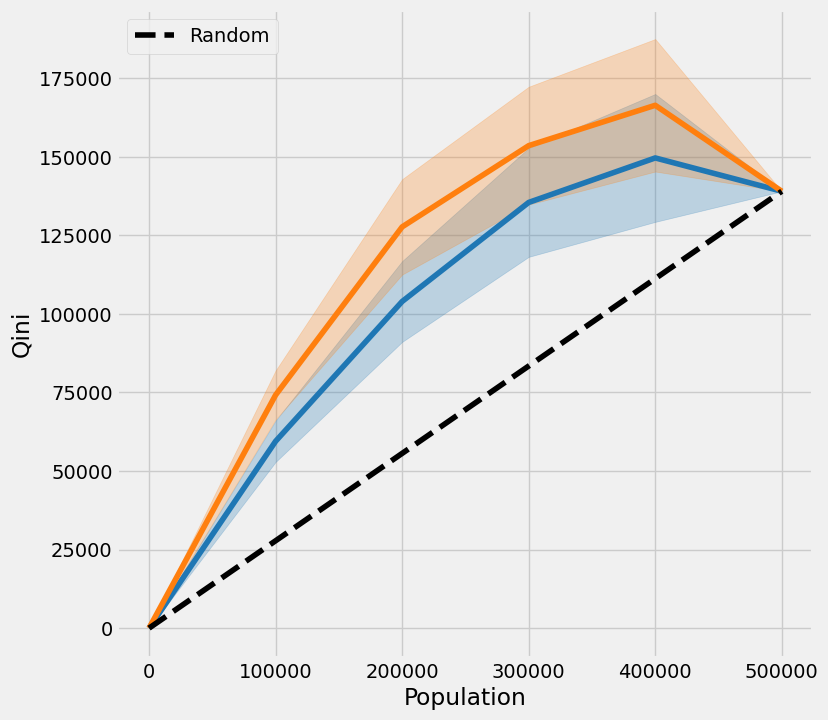

In [34]:
plot(df, kind='qini', tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=True)